My colab line:

https://colab.research.google.com/drive/1XM0R5cWjDszCFqIrzgcG3BEshUXMiKdc?usp=sharing

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import time

 I first pre-process the data by normalising it.

In [ ]:
train_set_C = torchvision.datasets.CIFAR10(
root="./",
download=True,
train=True,
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
)
test_set_C = torchvision.datasets.CIFAR10(
root="./",
download=True,
train=False,
transform=transforms.Compose([transforms.ToTensor(),  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
trainset_m = torchvision.datasets.MNIST(
root="./",
download=True,
train=True,
transform=transforms.Compose([transforms.ToTensor(),]),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(trainset_m.data.float().mean() / 255, trainset_m.data.float().std() / 255))

Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624


In [ ]:
train_set_M = torchvision.datasets.MNIST(
root="./",
download=True,
train=True,
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]),
)
test_set_M = torchvision.datasets.MNIST(
root="./",
download=True,
train=False,
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# set seed
SEED = 1727114
np.random.seed(SEED)
torch.manual_seed(SEED)

## Task1  Implement a fully-connected neural network: 
Implement a class s (class Net(nn.Module)) with two functions.

In [ ]:
class Net(nn.Module):
    
    def __init__(self, dim, nclass, width, depth):

        '''
        The function that initialises the layers that we will use. 
        Arguments:
            dim:  the dimension of the input
            nclass: the number of output classes for our prediction problem
            width: the width in each layer (we will consider all layers have the same width)
            depth: the depth of the neural network
        '''

        super(Net, self).__init__()
        self.dim = dim
        self.nclass = nclass
        self.width = width
        self.depth = depth
        self.flatten = nn.Flatten()  # a layer that flattens the input
        self.l1 = nn.Linear(dim, width) # a linear layer that takes the input and connects it to a hidden layer
        self.hidden = nn.ModuleList([nn.Linear(width, width) for i in range(depth-1)]) # a linear layer that takes a hidden layer and connects it to the next hidden layer
        self.relu = nn.ReLU() # a ReLU activation layer
        self.output = nn.Linear(width, nclass) # a linear layer that connects the hidden layer to the output.
        
    def forward(self, input):

        '''
        pass input through the layers and activation functions in the order
        '''
        
        x = self.flatten(input) # flatten layer
        x = self.l1(x) # Hidden layer 1
        for i in range(self.depth-1): # other hidden layers and ReLU activation function
            x = self.relu(x)
            x = self.hidden[i](x)
        x = self.relu(x) # ReLU activation function
        output = self.output(x) # Output layer
        return output

## Task2:

I use torch.utils.data.DataLoader, a tool that is able to partition a given dataset into subsets of a given batch size.

And to be faster, I shuffle the training set, in advance, and construct batches out of consecutive groups of Batch size datapoints. 

In [ ]:
def loading_data(batch_size, train_set, test_set):

    '''
    partitioning our training dataset to mini-batches.
    Arguments:
        batch_size: batch size for trainloader
        train_set: training set
        test_set: testing set
    return: dataloader for training and testing set
    '''
    torch.manual_seed(SEED)
    
    trainloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_set, batch_size)
    return trainloader, testloader

## Task3:
This function implements a single training epoch.

In [ ]:
def train_epoch(trainloader, net, optimizer, criterion):

    '''
    a function that does one testing epoch
    Arguments:
        trainloader: A dataloader containing the training features and labels.
        net:  A NN model.
        optimizer: The optimisation algorithm used for the backpropagation.
        criterion: The loss function used to train the model.

    Returns: the total training loss, the mean training loss
    '''

    total_loss = 0
    ntrain = 0
    loss_train_list = []
    for batch in trainloader:
        
        # get training features X and labels y in current batch
        X, y = batch
        y = y.to(torch.int64) # change data type
        
        # 1. get predictions
        preds = net(X)
        # 2. compute loss
        loss = criterion(preds, y)
        # 3. back propagation
        optimizer.zero_grad() # reset grads to zero
        loss.backward() # calculates gradients 
        optimizer.step() # update parameters

        # add minibatch loss to the total loss
        total_loss += loss.item()

        # to the total count
        ntrain += X.shape[0]

    
    return total_loss, total_loss/ntrain 

## Task4:

In [ ]:
def test_epoch(testloader, net, criterion):

    '''
    a function that does one test epoch
    Arguments:
        testloader: A dataloader containing the test features and labels.
        net:  A NN model.
        criterion: The loss function used to test the model.

    Returns: the mean test loss, the test error
    '''

    total_loss = 0
    wrong = 0
    ntest = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
     # change data type
    with torch.no_grad():
        for batch in testloader:
            X_test, y_test = batch
            y_test = y_test.to(torch.int64)

            # test loss
            preds_test = net(X_test)
            loss_test = criterion(preds_test, y_test)
            total_loss += loss_test.item()

            # the class with the highest energy is what we choose as prediction
            y_pred = torch.argmax(preds_test, dim = -1)
            ntest += X_test.shape[0]
            wrong += (y_pred != y_test).sum().item() 
            
    mean_loss = total_loss/ntest # mean test loss
    error = wrong/ntest # test error

    return mean_loss, error

## Task5: 

For this question, I first initialize the hyperparameters that we need and then create a for loop that runs over the number of epochs and computes for each epoch the train and test outputs. 

In [ ]:
def initialize_M(batch_size, width, depth, lr, momentum):

    '''
    set the initialization for training
    Arguments:
        batch_size: batch size for dataloader
        width: the width in each layer
        depth: the depth of the neural network
        lr: the learning rate
        momentum: the momentum to make convergence faster
    return: what we need to train and test the model,
    
    '''
    
    # load the datasets by loading_data I created in Task2
    trainloader, testloader = loading_data(batch_size = batch_size, train_set = train_set_M, test_set = test_set_M) 
    net = Net(dim=28*28, nclass=10,width=width,depth=depth)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum) # I use optim.SGD to be the optimizer
    criterion = nn.CrossEntropyLoss() 

    return trainloader, testloader, net, optimizer, criterion

In [ ]:
def nepoch(nepochs, trainloader, testloader, net, optimizer, criterion):

    '''
    create a for loop that runs over the number of epochs and computes for each epoch the train and test outputs
    Arguments:
        nepochs: the number of epochs
        trainloader, testloader: dataloader
        net: A NN model
        optimizer: optim.SGD, The optimisation algorithm used for the backpropagation.
        criterion: The loss function used to train the model.
    return: the mean train and test loss, the test error
    '''

    train_loss = [] # train loss list
    test_loss = [] # test loss list
    test_error = [] # test error list

    # for loop that runs over the number of epochs
    for epoch in range(nepochs):
        total_loss_train, mean_loss_train = train_epoch(trainloader, net, optimizer, criterion) 
        train_loss.append(mean_loss_train)

        mean_loss_test, error = test_epoch(testloader, net, criterion)
        test_loss.append(mean_loss_test)
        test_error.append(error)

        print(f'Epoch: {epoch:03} | Train Loss: {mean_loss_train:.04} |Test Loss: {mean_loss_test:.04} | Test Error: {error:.04}')

    return train_loss, test_loss, test_error

The next is I use my _initialize_M_ and _nepoch_ function. I set batch_size = 128, width = 256, depth = 1, lr = 0.01, momentum = 0.9. And I also print the mean train loss of the 10 epochs.

In [ ]:
n = 10
trainloader, testloader, net, optimizer, criterion = initialize_M(batch_size = 128, width = 256, depth = 1, lr = 0.01, momentum = 0.9)
train_loss, test_loss, test_error = nepoch(n, trainloader, testloader, net, optimizer, criterion)
train_loss

Epoch: 000 | Train Loss: 0.002706 |Test Loss: 0.001434 | Test Error: 0.0512
Epoch: 001 | Train Loss: 0.001209 |Test Loss: 0.0009739 | Test Error: 0.0356
Epoch: 002 | Train Loss: 0.0008583 |Test Loss: 0.0008195 | Test Error: 0.03
Epoch: 003 | Train Loss: 0.0006627 |Test Loss: 0.0007093 | Test Error: 0.0273
Epoch: 004 | Train Loss: 0.0005367 |Test Loss: 0.0006576 | Test Error: 0.0241
Epoch: 005 | Train Loss: 0.0004422 |Test Loss: 0.0006063 | Test Error: 0.0247
Epoch: 006 | Train Loss: 0.000372 |Test Loss: 0.0005552 | Test Error: 0.021
Epoch: 007 | Train Loss: 0.0003154 |Test Loss: 0.0005535 | Test Error: 0.0218
Epoch: 008 | Train Loss: 0.0002666 |Test Loss: 0.0005257 | Test Error: 0.0218
Epoch: 009 | Train Loss: 0.0002322 |Test Loss: 0.0005037 | Test Error: 0.0199


[0.0027056221393247444,
 0.001208964179456234,
 0.0008582965689400832,
 0.0006626885106787086,
 0.0005366539176398268,
 0.0004421573420986533,
 0.00037202669839995605,
 0.0003153858731656025,
 0.00026659810622998824,
 0.00023217092282138766]

Then I plot the _loss-nepochs_ and _test error-nepochs_ figures, we can find as nepochs increase, mean train and test loss decreases, test error decrease as well.

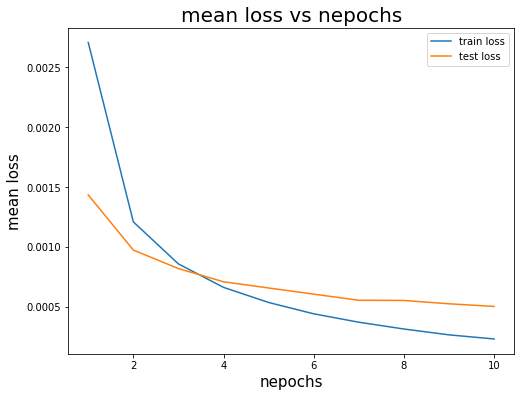

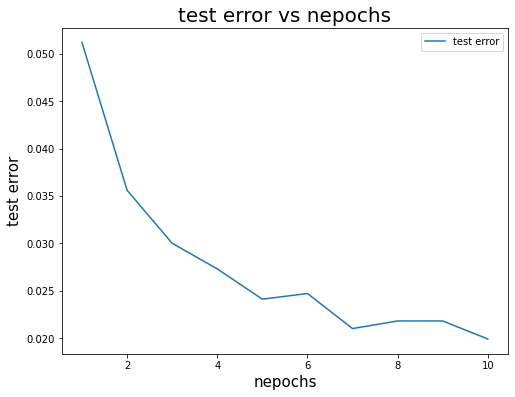

In [ ]:
plt.figure(figsize=(8,6))
x = np.arange(1, 11)
plt.plot(x, train_loss, label = 'train loss')
plt.plot(x, test_loss, label = 'test loss')
plt.title('mean loss vs nepochs', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, 11)
plt.plot(x, test_error, label = 'test error')
plt.title('test error vs nepochs', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('test error', size = 15)
plt.legend()
plt.show()

## Task6: Analyse thye performance for wide vs. deep neural networks
Observe the influence of depth, I choose depth = 1, 5, 10 to train the model. And I fix the number of nodes per layer to 256. I set my number of epoch to 100.

For other hyperparameters in task6, I set lr = 0.01, batch size=64. Here I set a small leraning rate because I use SGD to train.

The table below are the results that I present.

|Depth      | Train loss| Test loss|  Test Error
----------- | ----------- |----------|--------|       
 1     |    0.0001126   |  0.0009768    |   0.0186 |  
 5   |      1.889e-06 |     0.002197    |      0.0216   |
10   |      9.881e-06     |      0.005263  |    0.0285|


From the table above and the figures below, I find deeper network has higher test error(i.e.$0.0186 < 0.0216 < 0.0285$). And also we can see, deeper networks lead to more overfittling. For depth = 1, the train and test loss are 0.0001126 and 0.0009768. They do not have a huge gap, since we train the model by train set, the train loss is less, which is reasonable. But for depth = 5 and depth = 10, we can find the train loss are too small and the test loss are large comparing to the train loss. I only have 100 epochs here, if my epochs are larger, the train loss for depth = 10 will be the smallest, and looks the most overfitting.

We can also observe the overfit clearly in the below figures.

I think of the reason of overfitting for deeper networks: 

As the number of layers in a neural network increases, the number of learnable parameters in the network also increases. This increased capacity means that the network has more degrees of freedom to fit the training data, and thus it may learn to model the noise in the data as well. This can lead to overfitting, where the model performs well on the training data but poorly on test data.

In [ ]:
n = 100
trainloader1, testloader1, net1, optimizer1, criterion1 = initialize_M(batch_size = 64, width = 256, depth = 1, lr = 0.01, momentum = 0)
train_loss1, test_loss1, test_error1 = nepoch(n, trainloader1, testloader1, net1, optimizer1, criterion1)
trainloader2, testloader2, net2, optimizer2, criterion2 = initialize_M(batch_size = 64, width = 256, depth = 5, lr = 0.01, momentum = 0)
train_loss2, test_loss2, test_error2 = nepoch(n, trainloader2, testloader2, net2, optimizer2, criterion2)
trainloader3, testloader3, net3, optimizer3, criterion3 = initialize_M(batch_size = 64, width = 256, depth = 10, lr = 0.01, momentum = 0)
train_loss3, test_loss3, test_error3 = nepoch(n, trainloader3, testloader3, net3, optimizer3, criterion3)

Epoch: 000 | Train Loss: 0.008752 |Test Loss: 0.004893 | Test Error: 0.0862
Epoch: 001 | Train Loss: 0.00454 |Test Loss: 0.003949 | Test Error: 0.0704
Epoch: 002 | Train Loss: 0.003794 |Test Loss: 0.003483 | Test Error: 0.0637
Epoch: 003 | Train Loss: 0.003289 |Test Loss: 0.003019 | Test Error: 0.0548
Epoch: 004 | Train Loss: 0.002901 |Test Loss: 0.002741 | Test Error: 0.0511
Epoch: 005 | Train Loss: 0.002601 |Test Loss: 0.002514 | Test Error: 0.0475
Epoch: 006 | Train Loss: 0.002354 |Test Loss: 0.002298 | Test Error: 0.0425
Epoch: 007 | Train Loss: 0.002149 |Test Loss: 0.002153 | Test Error: 0.0399
Epoch: 008 | Train Loss: 0.001982 |Test Loss: 0.00205 | Test Error: 0.0389
Epoch: 009 | Train Loss: 0.001836 |Test Loss: 0.001886 | Test Error: 0.0348
Epoch: 010 | Train Loss: 0.001705 |Test Loss: 0.001789 | Test Error: 0.0334
Epoch: 011 | Train Loss: 0.001595 |Test Loss: 0.001692 | Test Error: 0.0315
Epoch: 012 | Train Loss: 0.001496 |Test Loss: 0.001636 | Test Error: 0.0312
Epoch: 013 | T

The next are the figures: _mean train/test loss-epochs_, _test error-epochs_. The green line is the depth = 10, we can see it will be convergent after more epochs.

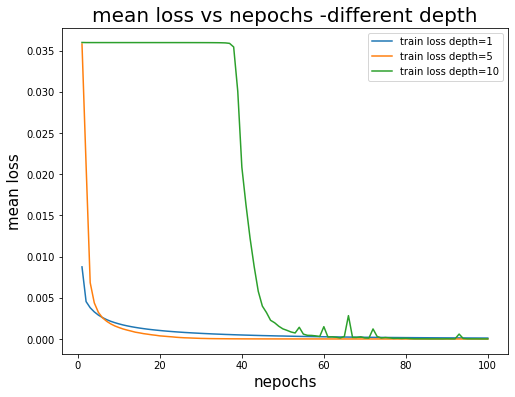

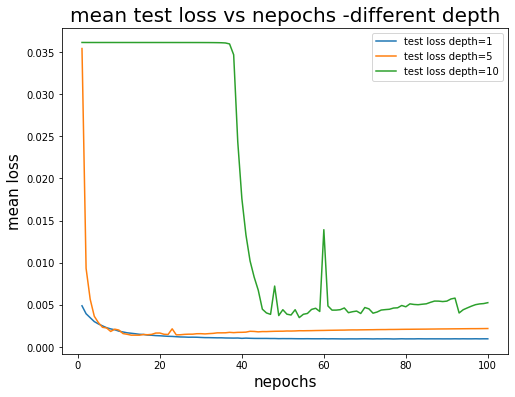

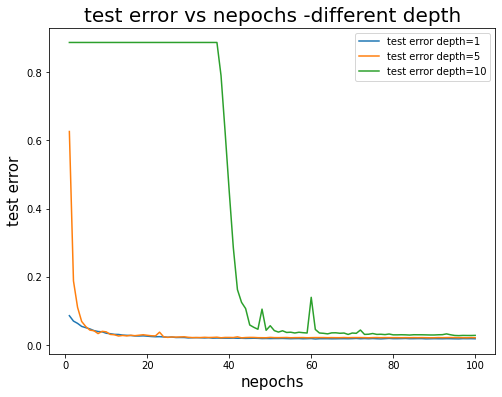

In [ ]:
plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, train_loss1, label = 'train loss depth=1')
plt.plot(x, train_loss2, label = 'train loss depth=5')
plt.plot(x, train_loss3, label = 'train loss depth=10')
plt.title('mean loss vs nepochs -different depth', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, test_loss1, label = 'test loss depth=1')
plt.plot(x, test_loss2, label = 'test loss depth=5')
plt.plot(x, test_loss3, label = 'test loss depth=10')
plt.title('mean test loss vs nepochs -different depth', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, test_error1, label = 'test error depth=1')
plt.plot(x, test_error2, label = 'test error depth=5')
plt.plot(x, test_error3, label = 'test error depth=10')
plt.title('test error vs nepochs -different depth', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('test error', size = 15)
plt.legend()
plt.show()

## Task7: Compare SGD with small and large learning rates

nepochs = 40

batchsize = 128

depth = 1, width = 256, momentum = 0.9

optimizer = optim.SGD

|Learning rate  | Train loss| Test loss|  Test Error
----------- | ----------- |----------|--------|       
0.001    |   0.0005024  |   0.0006679   |  0.0258 |  
 0.01   |      1.725e-05 |     0.0004933    |    0.0186 |
0.1   |      1.9e-07      |   0.0009013  |    0.0166|


Here, I use the SGD optimizer with momentum = 0.9 to be faster. From the plots, we can see for larger learning rates, the _loss-nepochs_ line becomes more steep, thus the convergent rate is faster. From the second picture, it is the _test loss-nepoch_, we can see clearly, learning rate = 0.1 overfit, i.e.small train loss and large test loss. This maybe because overshooting. Learning rate = 0.1 causes the SGD algorithm to take large steps in the direction of the gradient, it can overshoot the minimum of the cost function and continue to oscillate around it, rather than converging to the minimum.  

And for learning rate = 0.001, it converges too slow, error looks larger maybe because my number of epochs are only 40, and the 0.001 learning rate do not arrive the minimum. For learning rate = 0.1, although it converges fast, it may cause overshoot. So for this model, maybe learning rate = 0.01 is suitable to train. The test loss for 0.01 learning rate after 40 epochs is the smallest 0.0004933.

In [ ]:
n = 40
trainloader1, testloader1, net1, optimizer1, criterion1 = initialize_M(batch_size = 128, width = 256, depth = 1, lr = 0.001, momentum = 0.9)
train_loss1, test_loss1, test_error1 = nepoch(n, trainloader1, testloader1, net1, optimizer1, criterion1)
trainloader2, testloader2, net2, optimizer2, criterion2 = initialize_M(batch_size = 128, width = 256, depth = 1, lr = 0.01, momentum = 0.9)
train_loss2, test_loss2, test_error2 = nepoch(n, trainloader2, testloader2, net2, optimizer2, criterion2)
trainloader3, testloader3, net3, optimizer3, criterion3 = initialize_M(batch_size = 128, width = 256, depth = 1, lr = 0.1, momentum = 0.9)
train_loss3, test_loss3, test_error3 = nepoch(n, trainloader3, testloader3, net3, optimizer3, criterion3)

Epoch: 000 | Train Loss: 0.006288 |Test Loss: 0.003094 | Test Error: 0.1065
Epoch: 001 | Train Loss: 0.002841 |Test Loss: 0.002468 | Test Error: 0.0877
Epoch: 002 | Train Loss: 0.00241 |Test Loss: 0.002193 | Test Error: 0.0781
Epoch: 003 | Train Loss: 0.002164 |Test Loss: 0.002009 | Test Error: 0.0719
Epoch: 004 | Train Loss: 0.001984 |Test Loss: 0.001857 | Test Error: 0.0679
Epoch: 005 | Train Loss: 0.001839 |Test Loss: 0.00173 | Test Error: 0.0632
Epoch: 006 | Train Loss: 0.001711 |Test Loss: 0.001628 | Test Error: 0.0585
Epoch: 007 | Train Loss: 0.001604 |Test Loss: 0.001536 | Test Error: 0.0551
Epoch: 008 | Train Loss: 0.00151 |Test Loss: 0.001459 | Test Error: 0.0526
Epoch: 009 | Train Loss: 0.001424 |Test Loss: 0.001391 | Test Error: 0.0509
Epoch: 010 | Train Loss: 0.001349 |Test Loss: 0.001329 | Test Error: 0.0486
Epoch: 011 | Train Loss: 0.001281 |Test Loss: 0.001272 | Test Error: 0.0468
Epoch: 012 | Train Loss: 0.001218 |Test Loss: 0.001223 | Test Error: 0.0457
Epoch: 013 | Tr

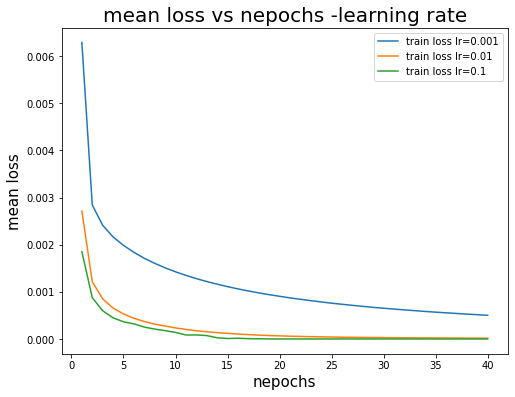

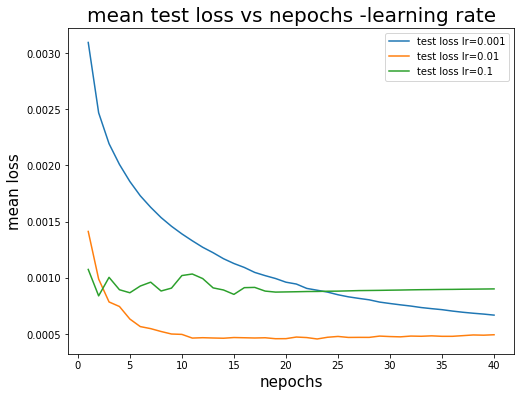

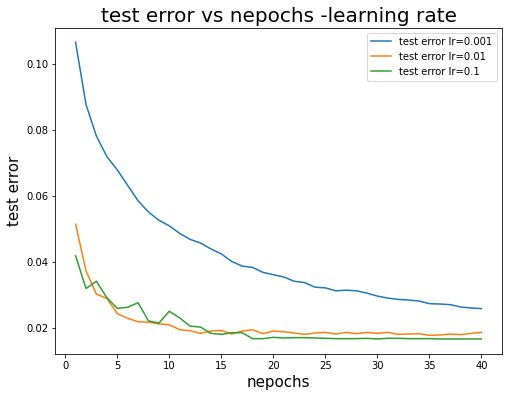

In [ ]:
plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, train_loss1, label = 'train loss lr=0.001')
plt.plot(x, train_loss2, label = 'train loss lr=0.01')
plt.plot(x, train_loss3, label = 'train loss lr=0.1')
plt.title('mean loss vs nepochs -learning rate', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, test_loss1, label = 'test loss lr=0.001')
plt.plot(x, test_loss2, label = 'test loss lr=0.01')
plt.plot(x, test_loss3, label = 'test loss lr=0.1')
plt.title('mean test loss vs nepochs -learning rate', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, test_error1, label = 'test error lr=0.001')
plt.plot(x, test_error2, label = 'test error lr=0.01')
plt.plot(x, test_error3, label = 'test error lr=0.1')
plt.title('test error vs nepochs -learning rate', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('test error', size = 15)
plt.legend()
plt.show()

## Task8:

In [ ]:
def train_epoch_b(trainloader, net, optimizer, criterion):

    '''
    a function that does one testing epoch
    Arguments:
        trainloader: A dataloader containing the training features and labels.
        net:  A NN model.
        optimizer: The optimisation algorithm used for the backpropagation.
        criterion: The loss function used to train the model.

    Returns: the total training loss, the mean training loss
    '''

    total_loss = 0
    ntrain = 0
    
    start_time = time.time()
    for batch in trainloader:
        
        # get training features X and labels y in current batch
        X, y = batch
        y = y.to(torch.int64) # change data type
        
        # 1. get predictions
        preds = net(X)
        # 2. compute loss
        loss = criterion(preds, y)
        # 3. back propagation
        optimizer.zero_grad() # reset grads to zero
        loss.backward() # calculates gradients 
        optimizer.step() # update parameters

        # add minibatch loss to the total loss
        total_loss += loss.item()

        # to the total count
        ntrain += X.shape[0]
    end_t = time.time()-start_time
    
    return end_t, total_loss/ntrain 

In [ ]:
def nepoch_b(nepochs, trainloader, testloader, net, optimizer, criterion):
    train_loss = []
    test_loss = []
    test_error = []
    t = []
    
    for epoch in range(nepochs):

        end_time, mean_loss_train = train_epoch_b(trainloader, net, optimizer, criterion)
        
        t.append(end_time)
        train_loss.append(mean_loss_train)

        mean_loss_test, error = test_epoch(testloader, net, criterion)
        test_loss.append(mean_loss_test)
        test_error.append(error)

        print(f'Epoch: {epoch:03} | Train Loss: {mean_loss_train:.04} |Test Loss: {mean_loss_test:.04} | Test Error: {error:.04}')
        
    

    return train_loss, test_loss, test_error, t

|Batch size | Train loss| Test loss|  Test Error
----------- | ----------- |----------|--------|       
8    | 2.288e-05  |    0.0159777  |   0.0244 |  
16   |    2.812e-05  |    0.0072740|    0.0231  |
32  |    4.011e-05   | 0.0037435   |  0.0255  |
64  |    6.419e-05    |    0.0013762 |   0.021 |
128 |    0.0001116  |   0.0006096  |  0.0231   |
256 |    0.0001411  |   0.0003228  |   0.0246  |
512 |     0.0001328 |   0.0001934   |  0.0282  |

First we compare the train loss, after 200 epochs, train loss turn to be stable. We can clearly find larger batch size causes latger train loss, but for batch size = 512, the train loss is a little bit lower than 256. And larger batch size always leads to smaller test loss from the table. For the generalization loss, the formula for this is: train loss-test loss. From my figure and the table, I only find smaller generalization loss with larger batchsize. But actually, it may be a U-shape and increase later. Maybe my epochs numbers are not large enough. 

My number of epochs are 200. From the table and figures, we can find smaller batch size causes larger test loss. Reasons:

1. With smaller batch sizes, the optimization algorithm may not be able to explore the parameter space effectively. The model may become stuck in a suboptimal local minimum, leading to larger test loss.

2. When using a small batch size, the gradient estimates used to update the model parameters are based on a smaller subset of the training data. This can lead to more variance in the updates, as each batch may contain a different set of examples. This higher variance can make it more difficult for the model to converge to an optimal solution and lead to a larger test loss.

3. The small batch size can cause the gradient estimates to be noisier, especially if the data is highly variable. This noise can lead to less accurate updates of the model parameters, which can lead to larger test loss.

For the computational efficiency, I want to discuss from two aspects: 
1. time: we can see as batch size increases, we need less time from the figure _'computional time vs batch size'_ .

2. iteration times while arriving same mean train loss, if for train loss < 0.001, batch size = 8 needs 20 epochs, batch size = 16 needs 24 epochs, batch size = 32 needs 29 epochs, batch size = 64 needs 28 epochs,  batch size = 128 needs 20 epochs, batch size = 256 needs 10 epochs and batch size = 512 needs 3 epochs. 

In summary for computational efficiency, larger batch size seems to have a higher computational efficiency. However, increasing the batch size also increases the memory requirements of the model. This may limit the batch size that can be used for a given model and hardware setup. Additionally, larger batch sizes may require larger learning rates or longer training times to achieve the same accuracy as smaller batch sizes, which can also impact the computational efficiency of the training process.

For the test error, small batch size and larger batch size have larger test error. Reasons:

1. A smaller batch size can lead to larger test errors because it can result in a less accurate estimate of the gradient, which in turn can lead to slower convergence or convergence to suboptimal solutions. When the batch size is too small, the model may learn to fit the noise in the training data, rather than the underlying patterns, which can result in poor generalization performance on the test set.

2. A smaller batch size may cause the model to take longer to converge, leading to a larger number of training epochs and potentially overfitting the training data.

3. A larger batch size can also lead to larger test errors because it may cause the model to become less flexible and less able to generalize to new data. With a larger batch size, the model may learn to fit the training data too closely, resulting in poor generalization performance on the test set. Additionally, larger batch sizes may require more memory and computational resources, which can limit the size of the model or the amount of training data that can be used.
 


In [ ]:
n = 200
trainloader1, testloader1, net1, optimizer1, criterion1 = initialize_M(batch_size = 8, width = 64, depth = 1, lr = 0.001, momentum = 0.9)
train_loss1, test_loss1, test_error1, time1 = nepoch_b(n, trainloader1, testloader1, net1, optimizer1, criterion1)
trainloader2, testloader2, net2, optimizer2, criterion2 = initialize_M(batch_size = 16, width = 64, depth = 1, lr = 0.001, momentum = 0.9)
train_loss2, test_loss2, test_error2, time2 = nepoch_b(n, trainloader2, testloader2, net2, optimizer2, criterion2)
trainloader3, testloader3, net3, optimizer3, criterion3 = initialize_M(batch_size = 32, width = 64, depth = 1, lr = 0.001, momentum = 0.9)
train_loss3, test_loss3, test_error3, time3 = nepoch_b(n, trainloader3, testloader3, net3, optimizer3, criterion3)
trainloader4, testloader4, net4, optimizer4, criterion4 = initialize_M(batch_size = 64, width = 64, depth = 1, lr = 0.001, momentum = 0.9)
train_loss4, test_loss4, test_error4, time4 = nepoch_b(n, trainloader4, testloader4, net4, optimizer4, criterion4)
trainloader5, testloader5, net5, optimizer5, criterion5 = initialize_M(batch_size = 128, width = 64, depth = 1, lr = 0.001, momentum = 0.9)
train_loss5, test_loss5, test_error5, time5 = nepoch_b(n, trainloader5, testloader5, net5, optimizer5, criterion5)
trainloader6, testloader6, net6, optimizer6, criterion6 = initialize_M(batch_size = 256, width = 64, depth = 1, lr = 0.001, momentum = 0.9)
train_loss6, test_loss6, test_error6, time6 = nepoch_b(n, trainloader6, testloader6, net6, optimizer6, criterion6)
trainloader7, testloader7, net7, optimizer7, criterion7 = initialize_M(batch_size = 512, width = 64, depth = 1, lr = 0.001, momentum = 0.9)
train_loss7, test_loss7, test_error7, time7 = nepoch_b(n, trainloader7, testloader7, net7, optimizer7, criterion7)

Epoch: 000 | Train Loss: 0.03636 |Test Loss: 0.02034 | Test Error: 0.0475
Epoch: 001 | Train Loss: 0.01785 |Test Loss: 0.01531 | Test Error: 0.0353
Epoch: 002 | Train Loss: 0.01314 |Test Loss: 0.01289 | Test Error: 0.0314
Epoch: 003 | Train Loss: 0.01043 |Test Loss: 0.01172 | Test Error: 0.0289
Epoch: 004 | Train Loss: 0.008713 |Test Loss: 0.01124 | Test Error: 0.0282
Epoch: 005 | Train Loss: 0.007384 |Test Loss: 0.01084 | Test Error: 0.0281
Epoch: 006 | Train Loss: 0.006519 |Test Loss: 0.01092 | Test Error: 0.0268
Epoch: 007 | Train Loss: 0.005616 |Test Loss: 0.01045 | Test Error: 0.0248
Epoch: 008 | Train Loss: 0.005082 |Test Loss: 0.009899 | Test Error: 0.0249
Epoch: 009 | Train Loss: 0.004414 |Test Loss: 0.009893 | Test Error: 0.025
Epoch: 010 | Train Loss: 0.003896 |Test Loss: 0.01043 | Test Error: 0.0255
Epoch: 011 | Train Loss: 0.003391 |Test Loss: 0.01013 | Test Error: 0.0257
Epoch: 012 | Train Loss: 0.002975 |Test Loss: 0.01004 | Test Error: 0.025
Epoch: 013 | Train Loss: 0.00

last epoch mean train loss 2.2880766866767314e-05
last epoch mean test loss 0.015977658507466824
last epoch mean train loss 2.8119678637498542e-05
last epoch mean test loss 0.007274022908945656
last epoch mean train loss 4.01060541980011e-05
last epoch mean test loss 0.003743509501076414
last epoch mean train loss 6.418583549335988e-05
last epoch mean test loss 0.0013761649728628981
last epoch mean train loss 0.00011164937414772188
last epoch mean test loss 0.0006095610182463133
last epoch mean train loss 0.00014112573725481829
last epoch mean test loss 0.0003227572676318232
last epoch mean train loss 0.0001328284440562129
last epoch mean test loss 0.000193427349627018
last epoch test error 0.0244
last epoch test error 0.0231
last epoch test error 0.0255
last epoch test error 0.021
last epoch test error 0.0231
last epoch test error 0.0246
last epoch test error 0.0282


Text(0.5, 1.0, ' genralisation losses vs batch size')

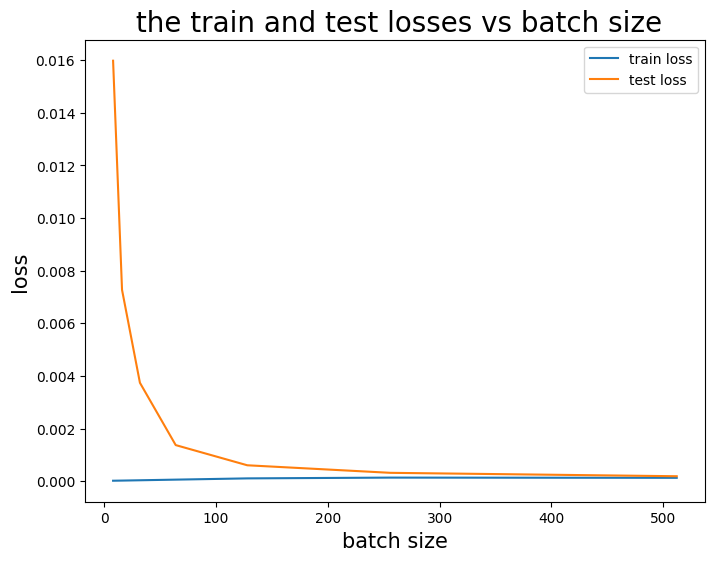

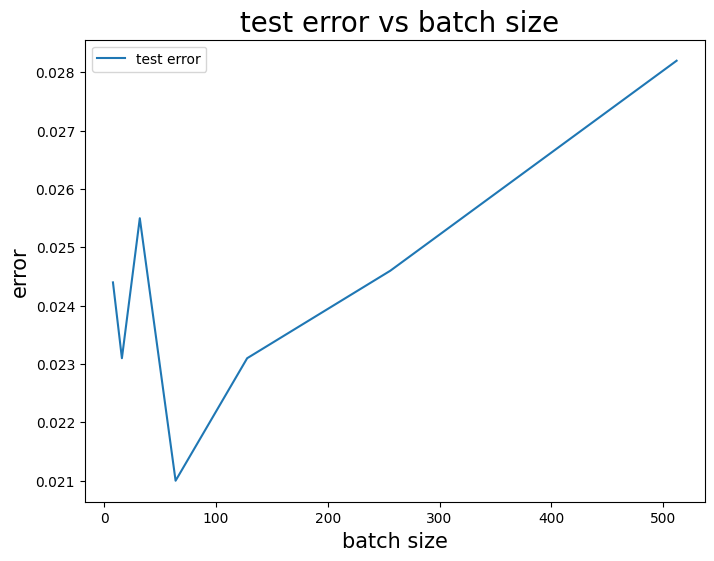

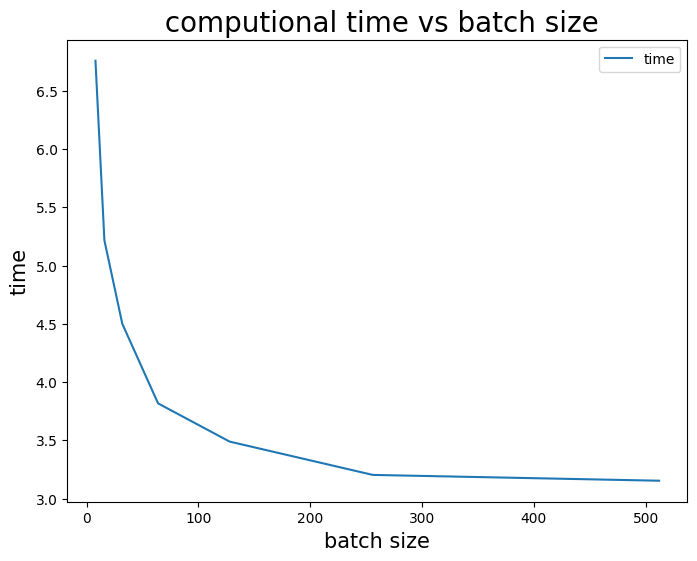

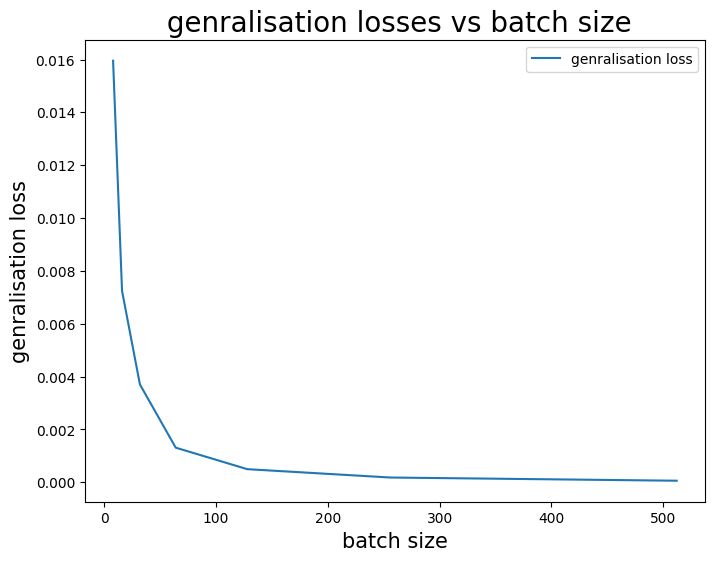

In [ ]:
batch_size = [8, 16, 32, 64, 128, 256, 512]
train_loss_list = [train_loss1, train_loss2, train_loss3, train_loss4, train_loss5, train_loss6, train_loss7]
test_loss_list =[test_loss1, test_loss2, test_loss3, test_loss4, test_loss5, test_loss6, test_loss7]
last_loss_train = []
last_loss_test = []
for i in range(7):
    last_loss_train.append(train_loss_list[i][-1])
    print('last epoch mean train loss',train_loss_list[i][-1])
    last_loss_test.append(test_loss_list[i][-1])
    print('last epoch mean test loss',test_loss_list[i][-1])
plt.figure(figsize=(8,6))
plt.plot(batch_size, last_loss_train, label = 'train loss')
plt.plot(batch_size, last_loss_test, label = 'test loss')
plt.xlabel('batch size', size = 15)
plt.ylabel('loss', size = 15)
plt.legend()
plt.title(' the train and test losses vs batch size', size = 20)

test_error_list = [test_error1, test_error2, test_error3, test_error4, test_error5, test_error6, test_error7]
error = []
for i in range(7):
    error.append(test_error_list[i][-1])
    print('last epoch test error',test_error_list[i][-1])
plt.figure(figsize=(8,6))
plt.plot(batch_size, error, label = 'test error')
plt.xlabel('batch size', size = 15)
plt.ylabel('error', size = 15)
plt.legend()
plt.title(' test error vs batch size', size = 20)

time_list = [time1, time2, time3, time4, time5, time6, time7]
t = []
for i in range(7):
    t.append(time_list[i][-1])
plt.figure(figsize=(8,6))
plt.plot(batch_size, t, label = 'time')
plt.xlabel('batch size', size = 15)
plt.ylabel('time', size = 15)
plt.legend()
plt.title(' computional time vs batch size', size = 20)

batch_size = [8, 16, 32, 64, 128, 256, 512]
genralisation_error = []
for i in range(7):
    genralisation_error.append(np.abs(train_loss_list[i][-1]-test_loss_list[i][-1]))
    
plt.figure(figsize=(8,6))
plt.plot(batch_size, genralisation_error, label = 'genralisation loss')
plt.xlabel('batch size', size = 15)
plt.ylabel('genralisation loss', size = 15)
plt.legend()
plt.title(' genralisation losses vs batch size', size = 20)

From the figures above, we can find the train and test loss are both arrive below 0.001. 

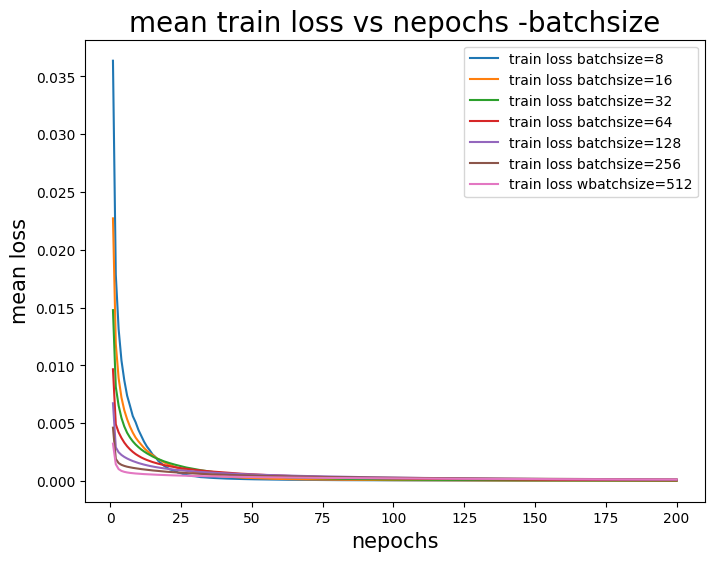

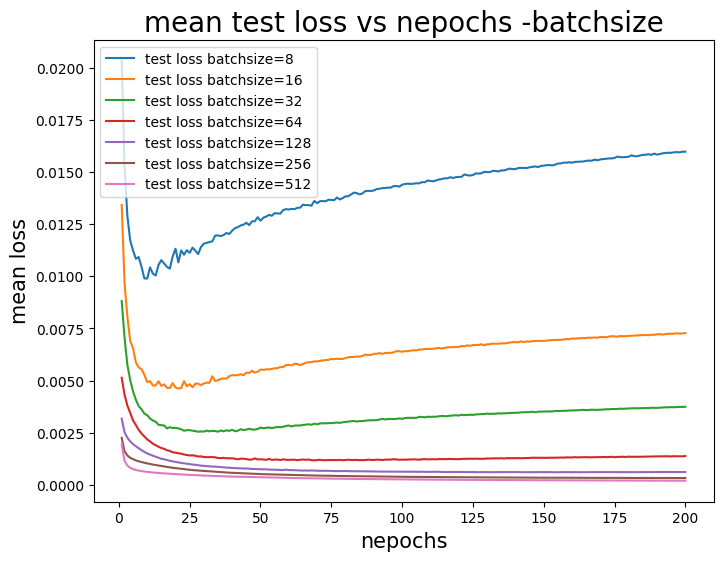

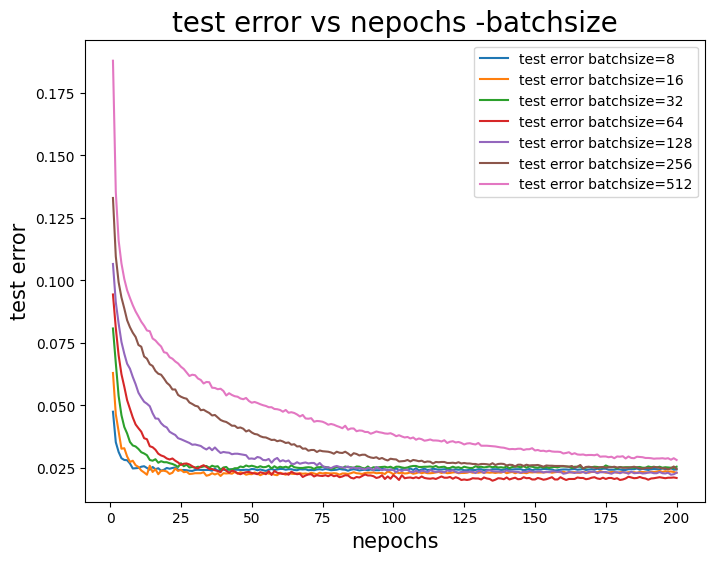

In [ ]:
plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, train_loss1, label = 'train loss batchsize=8')
plt.plot(x, train_loss2, label = 'train loss batchsize=16')
plt.plot(x, train_loss3, label = 'train loss batchsize=32')
plt.plot(x, train_loss4, label = 'train loss batchsize=64')
plt.plot(x, train_loss5, label = 'train loss batchsize=128')
plt.plot(x, train_loss6, label = 'train loss batchsize=256')
plt.plot(x, train_loss7, label = 'train loss wbatchsize=512')
plt.title('mean train loss vs nepochs -batchsize', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, test_loss1, label = 'test loss batchsize=8')
plt.plot(x, test_loss2, label = 'test loss batchsize=16')
plt.plot(x, test_loss3, label = 'test loss batchsize=32')
plt.plot(x, test_loss4, label = 'test loss batchsize=64')
plt.plot(x, test_loss5, label = 'test loss batchsize=128')
plt.plot(x, test_loss6, label = 'test loss batchsize=256')
plt.plot(x, test_loss7, label = 'test loss batchsize=512')

plt.title('mean test loss vs nepochs -batchsize', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, test_error1, label = 'test error batchsize=8')
plt.plot(x, test_error2, label = 'test error batchsize=16')
plt.plot(x, test_error3, label = 'test error batchsize=32')
plt.plot(x, test_error4, label = 'test error batchsize=64')
plt.plot(x, test_error5, label = 'test error batchsize=128')
plt.plot(x, test_error6, label = 'test error batchsize=256')
plt.plot(x, test_error7, label = 'test error batchsize=512')

plt.title('test error vs nepochs -batchsize', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('test error', size = 15)
plt.legend()
plt.show()

From the first figure above, from the steepness of the convergence line, we can indeed find larger batch size has a larger convergence rate. For train loss, they are stable to below 0.001 after about 30 epochs. But for the test loss, small batch size have diverge up shape later.

## Task9: Analyse the train and test errors as a function of width

I set depth = 1, batchsize = 128, learning rate = 0.01.  
I choose SGD optimizer, and set momentum = 0.9 to be faster.

|Width | Train loss| Test loss|  Test Error
----------- | ----------- |----------|--------|
4    |    0.0036675  |  0.0039589   |   0.1425 |   
8    |    0.0015702|   0.0019367  |  0.069  |  
16   |    0.0006411  |  0.0014492  |   0.0497   |
32  |    6.088e-05   |  0.0011007  |  0.0292  |
64  |      1.558e-05 |   0.0008303|   0.0236 |
128 |     1.075e-05  |  0.0006099   |  0.0191  |
256 |     9.276e-06  |  0.0005443  |  0.0193  |
512 |     8.48e-06  |  0.0004934  |  0.0166  |
1024 |      7.836e-06 |   0.0004672   |  0.0169  |

We can see from the table as well as the below figures, larger width leads to lower train and test loss. And I also observe larger width also leads to lower test error and more accurate more. These are reasons:

1. Increasing the width of a neural network increases the number of parameters in the model, leading to an increase in the model's capacity to fit the data. This increased capacity can allow the model to learn more complex patterns in the data and result in lower training and test loss.

2. As the width of the network increases, the gradients of the loss function with respect to the parameters can flow more easily through the network. This can result in more efficient and accurate parameter updates during training, which can lead to lower training and test loss.

3. A wider network can learn more diverse and richer features from the data. This can result in better representation learning, where the network can capture more high-level abstract features that are useful for predicting the target variable.

4. When training deep neural networks, the optimization process can sometimes suffer from vanishing or exploding gradients, which can make it difficult to train the model effectively. Increasing the width of the network can help alleviate this problem, resulting in more stable training dynamics and lower training and test loss.

As width increases, I can not observe overfitting due to with stochastic gradient descent there seems to be some implicit bias which does not allow this to happen.


In [ ]:
n = 60
trainloader1, testloader1, net1, optimizer1, criterion1 = initialize_M(batch_size = 128, width = 4, depth = 1, lr = 0.01, momentum = 0.9)
train_loss1, test_loss1, test_error1 = nepoch(n, trainloader1, testloader1, net1, optimizer1, criterion1)
trainloader2, testloader2, net2, optimizer2, criterion2 = initialize_M(batch_size = 128, width = 8, depth = 1, lr = 0.01, momentum = 0.9)
train_loss2, test_loss2, test_error2 = nepoch(n, trainloader2, testloader2, net2, optimizer2, criterion2)
trainloader3, testloader3, net3, optimizer3, criterion3 = initialize_M(batch_size = 128, width = 16, depth = 1, lr = 0.01, momentum = 0.9)
train_loss3, test_loss3, test_error3 = nepoch(n, trainloader3, testloader3, net3, optimizer3, criterion3)
trainloader4, testloader4, net4, optimizer4, criterion4 = initialize_M(batch_size = 128, width = 32, depth = 1, lr = 0.01, momentum = 0.9)
train_loss4, test_loss4, test_error4 = nepoch(n, trainloader4, testloader4, net4, optimizer4, criterion4)
trainloader5, testloader5, net5, optimizer5, criterion5 = initialize_M(batch_size = 128, width = 64, depth = 1, lr = 0.01, momentum = 0.9)
train_loss5, test_loss5, test_error5 = nepoch(n, trainloader5, testloader5, net5, optimizer5, criterion5)
trainloader6, testloader6, net6, optimizer6, criterion6 = initialize_M(batch_size = 128, width = 128, depth = 1, lr = 0.01, momentum = 0.9)
train_loss6, test_loss6, test_error6 = nepoch(n, trainloader6, testloader6, net6, optimizer6, criterion6)
trainloader7, testloader7, net7, optimizer7, criterion7 = initialize_M(batch_size = 128, width = 256, depth = 1, lr = 0.01, momentum = 0.9)
train_loss7, test_loss7, test_error7 = nepoch(n, trainloader7, testloader7, net7, optimizer7, criterion7)
trainloader8, testloader8, net8, optimizer8, criterion8 = initialize_M(batch_size = 128, width = 512, depth = 1, lr = 0.01, momentum = 0.9)
train_loss8, test_loss8, test_error8 = nepoch(n, trainloader8, testloader8, net8, optimizer8, criterion8)
trainloader9, testloader9, net9, optimizer9, criterion9 = initialize_M(batch_size = 128, width = 1024, depth = 1, lr = 0.01, momentum = 0.9)
train_loss9, test_loss9, test_error9 = nepoch(n, trainloader9, testloader9, net9, optimizer9, criterion9)

Epoch: 000 | Train Loss: 0.006644 |Test Loss: 0.00463 | Test Error: 0.1697
Epoch: 001 | Train Loss: 0.004576 |Test Loss: 0.004617 | Test Error: 0.175
Epoch: 002 | Train Loss: 0.004272 |Test Loss: 0.004348 | Test Error: 0.1556
Epoch: 003 | Train Loss: 0.004207 |Test Loss: 0.004123 | Test Error: 0.1505
Epoch: 004 | Train Loss: 0.004139 |Test Loss: 0.004107 | Test Error: 0.1523
Epoch: 005 | Train Loss: 0.004072 |Test Loss: 0.004029 | Test Error: 0.1489
Epoch: 006 | Train Loss: 0.004046 |Test Loss: 0.004073 | Test Error: 0.1475
Epoch: 007 | Train Loss: 0.004008 |Test Loss: 0.004118 | Test Error: 0.1531
Epoch: 008 | Train Loss: 0.003971 |Test Loss: 0.004118 | Test Error: 0.15
Epoch: 009 | Train Loss: 0.003961 |Test Loss: 0.004098 | Test Error: 0.1446
Epoch: 010 | Train Loss: 0.003938 |Test Loss: 0.004058 | Test Error: 0.1453
Epoch: 011 | Train Loss: 0.003922 |Test Loss: 0.004233 | Test Error: 0.1577
Epoch: 012 | Train Loss: 0.003912 |Test Loss: 0.004084 | Test Error: 0.145
Epoch: 013 | Trai

last epoch mean train loss 0.003667498132586479
last epoch mean test loss 0.003958884440362453
last epoch mean train loss 0.0015702466741204261
last epoch mean test loss 0.0019367307004518807
last epoch mean train loss 0.0006411166442247729
last epoch mean test loss 0.0014491550878155976
last epoch mean train loss 6.087562272053522e-05
last epoch mean test loss 0.0011006993015231273
last epoch mean train loss 1.5580610737015377e-05
last epoch mean test loss 0.000830339931909566
last epoch mean train loss 1.0752668318309588e-05
last epoch mean test loss 0.0006098846379499264
last epoch mean train loss 9.276443083702665e-06
last epoch mean test loss 0.000544282649401157
last epoch mean train loss 8.480211840408932e-06
last epoch mean test loss 8.480211840408932e-06
last epoch mean train loss 7.836027917801403e-06
last epoch mean test loss 7.836027917801403e-06
last epoch test error 0.1425
last epoch test error 0.069
last epoch test error 0.0497
last epoch test error 0.0292
last epoch tes

Text(0.5, 1.0, ' test error vs width')

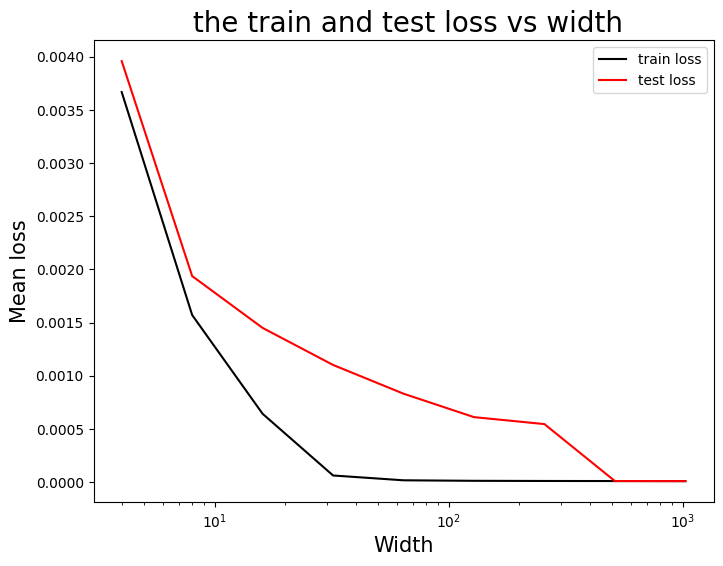

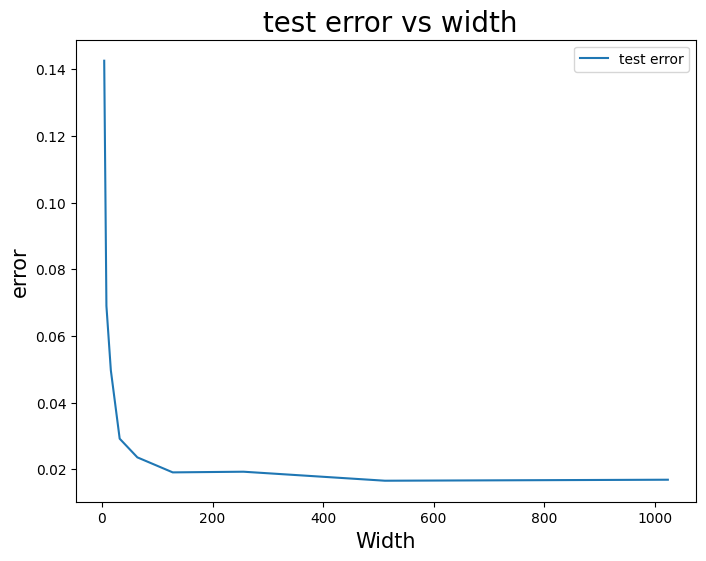

In [ ]:
width = [4, 8, 16, 32, 64, 128, 256, 512,1024]
train_loss_list = [train_loss1, train_loss2, train_loss3, train_loss4, train_loss5, train_loss6, train_loss7, train_loss8, train_loss9]
test_loss_list =[test_loss1, test_loss2, test_loss3, test_loss4, test_loss5, test_loss6, test_loss7, train_loss8, train_loss9]
last_loss_train = []
last_loss_test = []
for i in range(9):
    last_loss_train.append(train_loss_list[i][-1])
    print('last epoch mean train loss',train_loss_list[i][-1])
    last_loss_test.append(test_loss_list[i][-1])
    print('last epoch mean test loss',test_loss_list[i][-1])

plt.figure(figsize=(8,6))
plt.semilogx(width, last_loss_train, 'black', label = 'train loss')
plt.semilogx(width, last_loss_test, 'red',label = 'test loss')
plt.xlabel('Width', size = 15)
plt.ylabel('Mean loss', size = 15)
plt.legend()
plt.title(' the train and test loss vs width', size = 20)

test_error_list = [test_error1, test_error2, test_error3, test_error4, test_error5, test_error6, test_error7, test_error8, test_error9]
error = []
for i in range(9):
    error.append(test_error_list[i][-1])
    print('last epoch test error',test_error_list[i][-1])
plt.figure(figsize=(8,6))
plt.plot(width, error, label = 'test error')
plt.xlabel('Width', size = 15)
plt.ylabel('error', size = 15)
plt.legend()
plt.title(' test error vs width', size = 20)

From the figures above, I indeed find larger width lead to less test error.

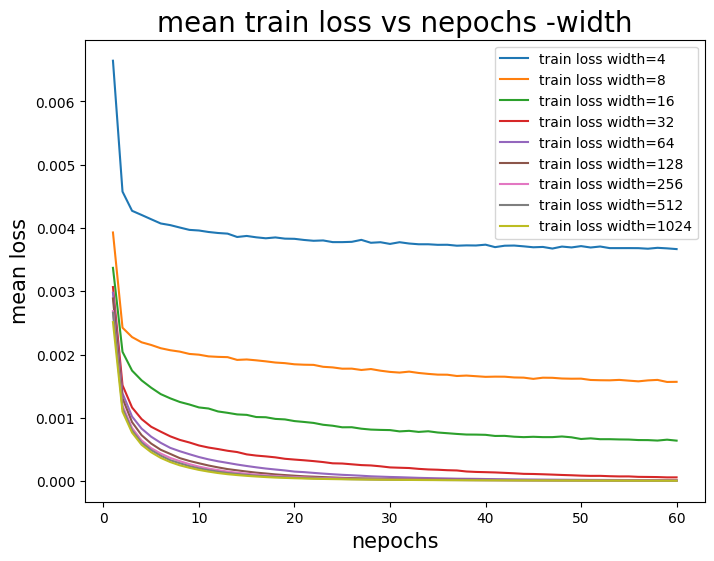

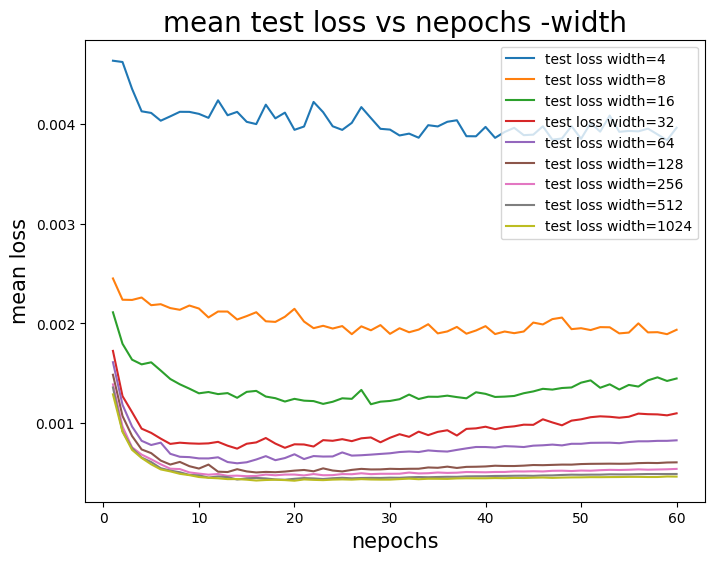

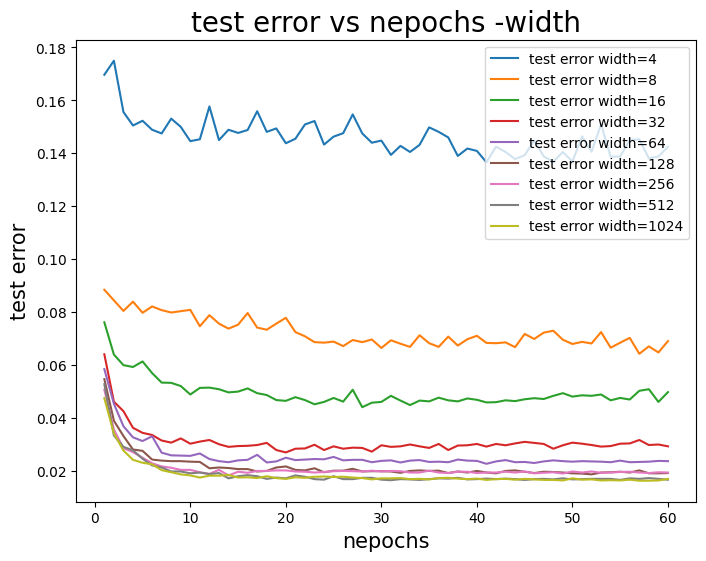

In [ ]:
plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, train_loss1, label = 'train loss width=4')
plt.plot(x, train_loss2, label = 'train loss width=8')
plt.plot(x, train_loss3, label = 'train loss width=16')
plt.plot(x, train_loss4, label = 'train loss width=32')
plt.plot(x, train_loss5, label = 'train loss width=64')
plt.plot(x, train_loss6, label = 'train loss width=128')
plt.plot(x, train_loss7, label = 'train loss width=256')
plt.plot(x, train_loss8, label = 'train loss width=512')
plt.plot(x, train_loss9, label = 'train loss width=1024')
plt.title('mean train loss vs nepochs -width', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, test_loss1, label = 'test loss width=4')
plt.plot(x, test_loss2, label = 'test loss width=8')
plt.plot(x, test_loss3, label = 'test loss width=16')
plt.plot(x, test_loss4, label = 'test loss width=32')
plt.plot(x, test_loss5, label = 'test loss width=64')
plt.plot(x, test_loss6, label = 'test loss width=128')
plt.plot(x, test_loss7, label = 'test loss width=256')
plt.plot(x, test_loss8, label = 'test loss width=512')
plt.plot(x, test_loss9, label = 'test loss width=1024')
plt.title('mean test loss vs nepochs -width', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, test_error1, label = 'test error width=4')
plt.plot(x, test_error2, label = 'test error width=8')
plt.plot(x, test_error3, label = 'test error width=16')
plt.plot(x, test_error4, label = 'test error width=32')
plt.plot(x, test_error5, label = 'test error width=64')
plt.plot(x, test_error6, label = 'test error width=128')
plt.plot(x, test_error7, label = 'test error width=256')
plt.plot(x, test_error8, label = 'test error width=512')
plt.plot(x, test_error9, label = 'test error width=1024')
plt.title('test error vs nepochs -width', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('test error', size = 15)
plt.legend()
plt.show()

These figures above shows that larger width can also be convergent and also not too overfitting. Maybe from here, we can think of using larger width while train the model.

## Task10:

Here, I first load the dataset CIFAR10, and set my hyperparameters:

width = 2048, since large width is not easy to overfit, so I choose this relatively large width.

batch size = 128, I choose this proper batch size to make sure the less test error and the good computational efficiency.

depth = 2, I slightly increase the depth to 2, too large depth will cause overfit as we discuss before, so I use depth = 2.

learning rate = 0.01, I discuss this in task7 and 0.01 is good because it converges fast and not easy to overshoot.

In [ ]:

def initialize_C(batch_size, width, depth, lr, momentum):
    
    '''
    set the initialization for training by CIFAR10
    Arguments:
        batch_size: batch size for dataloader
        width: the width in each layer
        depth: the depth of the neural network
        lr: the learning rate
        momentum: the momentum to make convergence faster
    return: what we need to train and test the model,
    
    '''
    
    trainloader, testloader = loading_data(batch_size = batch_size, train_set = train_set_C, test_set = test_set_C)
    net = Net(dim=3072, nclass=10,width=width,depth=depth)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    return trainloader, testloader, net, optimizer, criterion

In [ ]:
n = 50
trainloader, testloader, net, optimizer, criterion = initialize_C(batch_size = 128, width = 2048, depth = 2, lr = 0.01, momentum = 0.9)
train_loss, test_loss, test_error = nepoch(n, trainloader, testloader, net, optimizer, criterion)
test_error

Epoch: 000 | Train Loss: 0.01359 |Test Loss: 0.01215 | Test Error: 0.5461
Epoch: 001 | Train Loss: 0.01137 |Test Loss: 0.01123 | Test Error: 0.5049
Epoch: 002 | Train Loss: 0.01038 |Test Loss: 0.01085 | Test Error: 0.4868
Epoch: 003 | Train Loss: 0.009598 |Test Loss: 0.01064 | Test Error: 0.4709
Epoch: 004 | Train Loss: 0.008886 |Test Loss: 0.01041 | Test Error: 0.4609
Epoch: 005 | Train Loss: 0.008286 |Test Loss: 0.01062 | Test Error: 0.4683
Epoch: 006 | Train Loss: 0.007661 |Test Loss: 0.0103 | Test Error: 0.4472
Epoch: 007 | Train Loss: 0.007069 |Test Loss: 0.01013 | Test Error: 0.4392
Epoch: 008 | Train Loss: 0.006476 |Test Loss: 0.01044 | Test Error: 0.4435
Epoch: 009 | Train Loss: 0.005882 |Test Loss: 0.01087 | Test Error: 0.4463
Epoch: 010 | Train Loss: 0.005234 |Test Loss: 0.01092 | Test Error: 0.4493
Epoch: 011 | Train Loss: 0.004762 |Test Loss: 0.0117 | Test Error: 0.4522
Epoch: 012 | Train Loss: 0.004173 |Test Loss: 0.01204 | Test Error: 0.4413
Epoch: 013 | Train Loss: 0.003

[0.5461,
 0.5049,
 0.4868,
 0.4709,
 0.4609,
 0.4683,
 0.4472,
 0.4392,
 0.4435,
 0.4463,
 0.4493,
 0.4522,
 0.4413,
 0.4442,
 0.448,
 0.4431,
 0.4423,
 0.4353,
 0.4495,
 0.4496,
 0.4264,
 0.445,
 0.4314,
 0.4323,
 0.4277,
 0.4403,
 0.4323,
 0.4268,
 0.4265,
 0.4221,
 0.4224,
 0.4247,
 0.4183,
 0.4179,
 0.4213,
 0.4161,
 0.4151,
 0.4164,
 0.4181,
 0.4146,
 0.4183,
 0.4162,
 0.4167,
 0.4158,
 0.4164,
 0.4169,
 0.4172,
 0.4178,
 0.4165,
 0.4168]

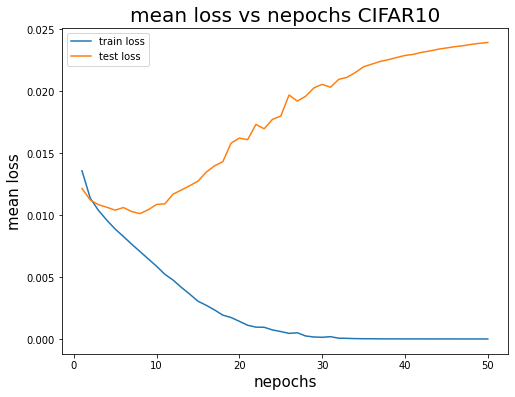

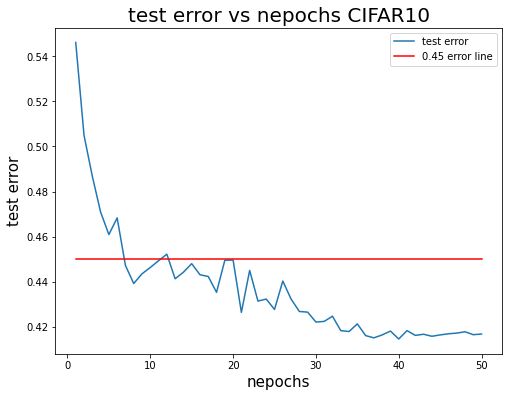

In [ ]:
plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
plt.plot(x, train_loss, label = 'train loss')
plt.plot(x, test_loss, label = 'test loss')
plt.title('mean loss vs nepochs CIFAR10', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('mean loss', size = 15)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
x = np.arange(1, n+1)
f = 0.45*np.ones(n)
plt.plot(x, test_error, label = 'test error')
plt.plot(x, f,'red', label = '0.45 error line')
plt.title('test error vs nepochs CIFAR10', size = 20)
plt.xlabel('nepochs', size = 15)
plt.ylabel('test error', size = 15)
plt.legend()
plt.show()

From the pictures above, we clearly see the test error is smaller than 0.45, which means the test accuracy using only fully-connected layers is  larger than 0.55.

Comparing MNIST or CIFAR10, clearly, MNIST is easier to train. The test error for MINST can be smaller than 0.1 easily. But for CIFAR10, it is even difficult for the test error of it to be smaller than 0.45. It is 0.4168 after 50 epochs. The following are the possible reasons:

1. Complexity of the dataset: The MNIST dataset consists of grayscale images of handwritten digits that are relatively simple in terms of their visual complexity. On the other hand, the CIFAR10 dataset consists of color images of everyday objects such as animals and vehicles, which are more complex and varied.

2. Model complexity: The MNIST dataset can be accurately classified using relatively simple models such as logistic regression or shallow neural networks. On the other hand, the CIFAR10 dataset may require more complex models with deeper neural networks and more advanced techniques such as convolutional neural networks (CNNs).

3. Preprocessing: The MNIST dataset is preprocessed to normalize the pixel values to a standard scale, which simplifies the training process. The CIFAR10 dataset requires more preprocessing such as data augmentation to improve the model's ability to generalize to new data.